# Development of BOA

In [101]:
# imports
from importlib import reload
import os

import numpy as np
import h5py
import xarray
import pandas

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec

from skimage import morphology

from wrangler.plotting import cutout
from wrangler.ogcm import llc as wr_llc

from fronts.pyboa import pyboa
from fronts.llc import extract

# Load up training data

In [7]:
## B = Inputs = Div SST, SSS, SST 
        #   Targets = Divb2 

In [8]:
b_tblfile = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Fronts', 'Training_Sets', 
                     'LLC4320_SST144_SSS40_trainB.parquet')
b_file = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Fronts', 'Training_Sets', 
                     'LLC4320_SST144_SSS40_trainB.h5')

In [9]:
b_train = h5py.File(b_file, 'r')
b_train.keys()

<KeysViewHDF5 ['inputs', 'targets']>

In [10]:
b_tbl = pandas.read_parquet(b_tblfile)
b_tbl.iloc[500]

lat                                                  -28.979555
lon                                                  -158.90625
row                                                        6310
col                                                       11444
datetime                                    2011-12-25 00:00:00
UID                                           13246102042109375
filename      /data/Projects/Oceanography/data/LLC/ThetaUVSa...
pp_file                                                        
pp_root                       llc4320_sst144_sss40_extract.json
field_size                                                   64
pp_type                                                       0
SSTmax                                                24.571771
SSTmin                                                22.414863
SST10                                                 23.131249
SST90                                                 24.349434
SSTmu                                   

In [11]:
def parse_idx(idx):
    # Parase
    div_sst = b_train['inputs'][idx, 0, 0, ...]
    sst = b_train['inputs'][idx, 2, 0, ...]
    sss = b_train['inputs'][idx, 1, 0, ...]
    #
    Divb2 = b_train['targets'][idx, 0, 0, ...]
    #
    return div_sst, sst, sss, Divb2

In [12]:
def plot_example(idx):
    div_sst, sst, sss, Divb2 = parse_idx(idx)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    cutout.show_image(sst, clbl='SST (deg C)', ax=ax1)
    cutout.show_image(div_sst, clbl=r'|Div SST|$^2$', cm='viridis', ax=ax2)
    #cutout.show_image(sss, clbl='SSS (psu)', cm='viridis', ax=ax2)
    cutout.show_image(Divb2, clbl=r'$\nabla b^2$', cm='Greys', ax=ax3)
    #
    plt.show()

In [13]:
def arr_to_dataset(arr):
    ds = xarray.Dataset({
    'data': (['x', 'y'], arr)}, coords={
    'x': range(arr.shape[0]),  # 0, 1, 2, ..., 9
    'y': range(arr.shape[1]),  # 0, 1, 2, 3, 4
    })
    return ds

# Try it

## Pick one

In [81]:
idx = 500
div_sst, sst, sss, Divb2 = parse_idx(idx)

### Plot it

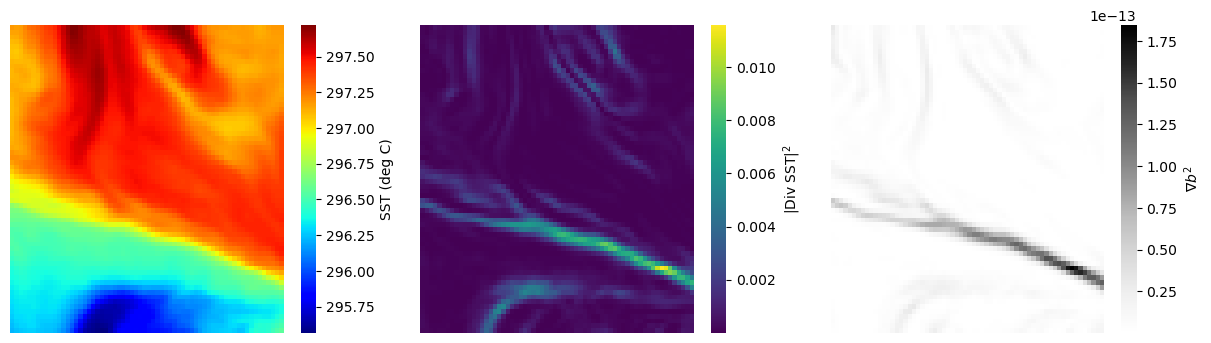

In [82]:
plot_example(idx)

## PyBOA

## Plot em

In [80]:
def plot_fronts(idx, res_fronts, clr='g'):
    div_sst, sst, sss, Divb2 = parse_idx(idx)

    # Plot
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    #
    cutout.show_image(Divb2, cbar=False, #clbl=r'$\nabla b^2$', 
                      cm='Greys', ax=ax)
    #cutout.show_image(np.flipud(pp_fields[0]), cbar=False, #clbl=r'$\nabla b^2$', 
    #                  cm='Greys', ax=ax)
    #cutout.show_image(np.flipud(pp_fields2[0]), cbar=False, #clbl=r'$\nabla b^2$', 
    #                  cm='Greys', ax=ax)
    #cutout.show_image(np.flipud(boa.isel(time=0).data_sobel), cbar=False, #clbl=r'$\nabla b^2$', 
    #                  cm='Blues', ax=ax)
    # BOA
    #col,row = np.where(np.isfinite(boa.data_fronts.isel(time=0).data))
    #ax.scatter(row, col, s=1.0, color='red', marker='s')
    col,row = np.where(np.flipud(res_fronts))
    ax.scatter(row, col, s=1.0, color=clr)
    #
    plt.show()

## Apply to $|\nabla b|^2$ image

In [32]:
#res_frnt = pyboa_b2.front_trsh(prcnt=80).pyBOA.thinning(f_dilate=True)

## pyBOA threshold

In [83]:
divb2_ds = arr_to_dataset(Divb2)
pyboa_b2 = pyboa.pyBOA(divb2_ds)
res_frnt2 = pyboa_b2.front_trsh(prcnt=90)
#res_ds = arr_to_dataset(res_frnt.isel(time=0).data.data)
#res_pyboa = pyBOA.pyBOA(res_ds)
#res_frnt = res_pyboa.thinning(f_dilate=True)
#res_frnt
#res_pyboa._array
#res_frnt2 = res_pyboa.thinning(f_dilate=True)

In [84]:
np.sum(res_frnt2)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    data     int64 8B 401

## Numpy

In [85]:
res_frnt_np = pyboa.front_thresh(Divb2, wndw=40)
res_frnt_np.shape

(64, 64)

In [86]:
np.sum(res_frnt_np)

np.int64(415)

In [87]:
np.all(res_frnt_np == res_frnt2.isel(time=0).data.data)

np.False_

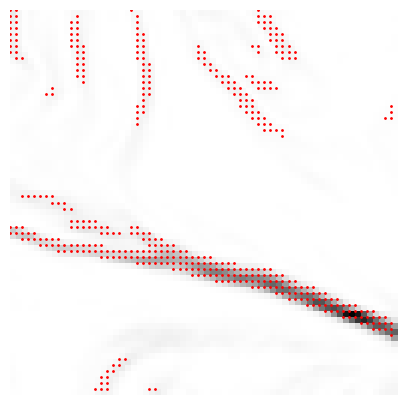

In [88]:
plot_fronts(idx, res_frnt_np, clr='r')

## Crop

In [89]:
reload(pyboa)
res_frnt_crop = pyboa.cropping(res_frnt_np)

/home/xavier/Projects/Oceanography/python/fronts/fronts/pyboa/pyboa.py:414: AccessorRegistrationWarning: registration of accessor <class 'fronts.pyboa.pyboa.pyBOA'> under name 'pyBOA' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @xr.register_dataset_accessor("pyBOA")
/home/xavier/Projects/Oceanography/python/fronts/fronts/pyboa/pyboa.py:413: AccessorRegistrationWarning: registration of accessor <class 'fronts.pyboa.pyboa.pyBOA'> under name 'pyBOA' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor("pyBOA")


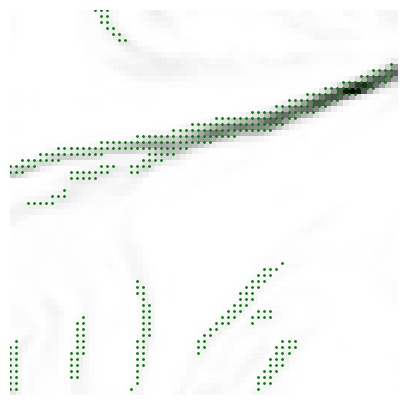

In [67]:
plot_fronts(idx, res_frnt_crop)

# Try another (weak fronts)

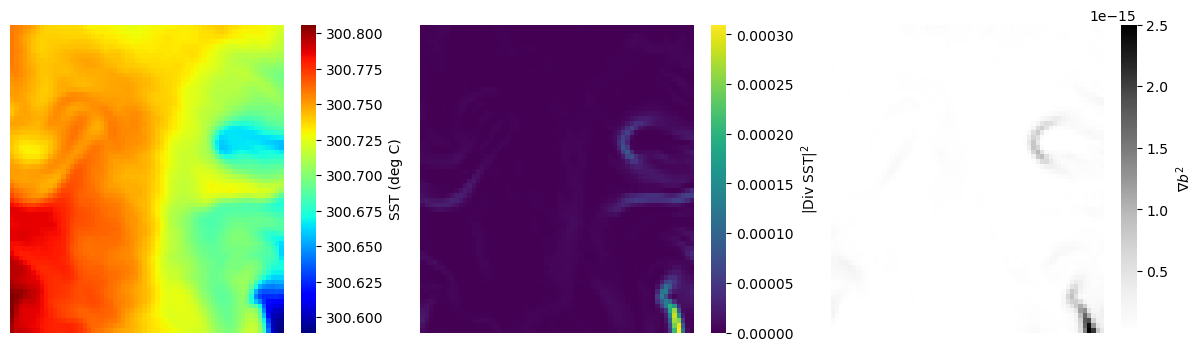

In [91]:
idx = 0
div_sst, sst, sss, Divb2 = parse_idx(idx)
plot_example(idx)

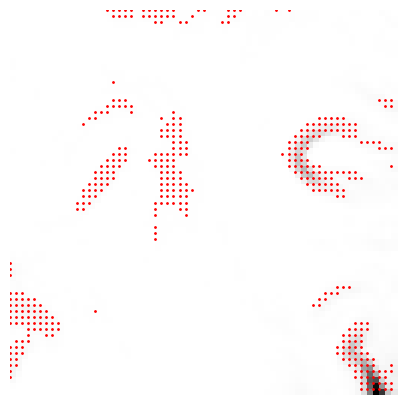

In [93]:
res_frnt_np = pyboa.front_thresh(Divb2, wndw=40)
plot_fronts(idx, res_frnt_np, clr='r')

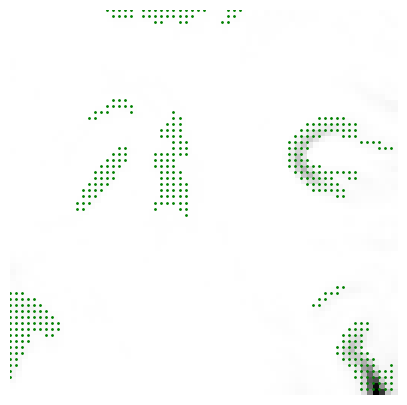

In [94]:
res_frnt_crop = pyboa.cropping(res_frnt_np)
plot_fronts(idx, res_frnt_crop)

# One more (stronger fronts)

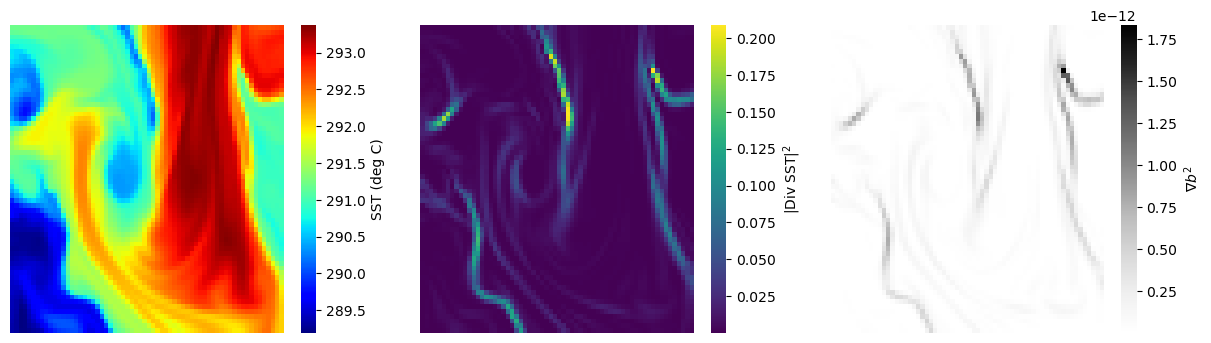

In [95]:
idx = 700
div_sst, sst, sss, Divb2 = parse_idx(idx)
plot_example(idx)

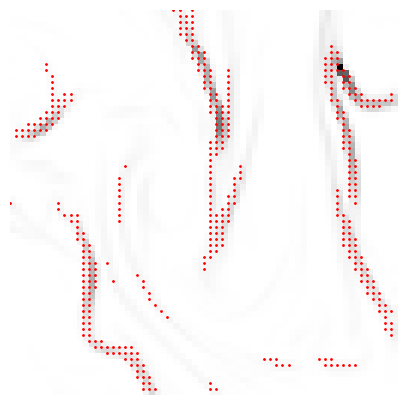

In [96]:
res_frnt_np = pyboa.front_thresh(Divb2, wndw=40)
plot_fronts(idx, res_frnt_np, 'r')

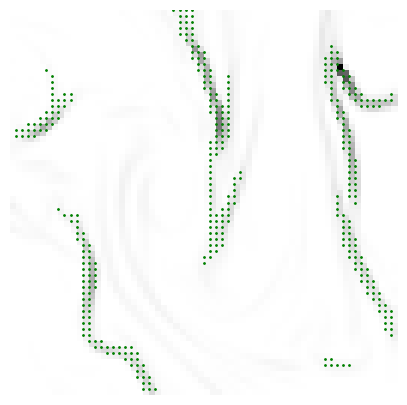

In [97]:
res_frnt_crop = pyboa.cropping(res_frnt_np)
plot_fronts(idx, res_frnt_crop)

# Stack of 6 figures

In [105]:
reload(pyboa)
idx = 700
sv_sst, sv_divb2, sv_fronts = [], [], []
for idx in [0,500,700]:
    div_sst, sst, sss, Divb2 = parse_idx(idx)
    frnts = pyboa.fronts_in_divb2(Divb2)
    # Save
    sv_sst.append(sst)
    sv_divb2.append(Divb2)
    sv_fronts.append(frnts)

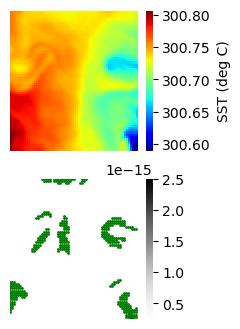

In [111]:
fig = plt.figure(figsize=(7,4))
plt.clf()
gs = gridspec.GridSpec(2,3)

# First pair
col = 0
ax_img = plt.subplot(gs[0, col])
cutout.show_image(sv_sst[col], clbl='SST (deg C)', ax=ax_img)
ax_fronts = plt.subplot(gs[1, col])
mx_div = sv_divb2[col].max()
mn_div = mx_div / 10.
cutout.show_image(sv_divb2[col], cbar=True, #clbl=r'$\nabla b^2$', 
                      cm='Greys', ax=ax_fronts, vmnx=(mn_div,mx_div))
col,row = np.where(np.flipud(sv_fronts[col]))
ax_fronts.scatter(row, col, s=1.0, color='g')

plt.show()